# Make a Gardner-Altman Plot

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Get seaborn's fMRI dataset but remove the time variable & group it
df = sns.load_dataset('fmri')
df['subject'] = df['subject'].str.extract('(\d+)').astype(int)
df = df.sort_values(by='subject').reset_index(drop=True)
df = df.groupby(['subject', 'event', 'region'], as_index=False)['signal'].mean()
df.head(16)

,subject,event,region,signal
0,0,cue,frontal,0.013769
1,0,cue,parietal,0.006717
2,0,stim,frontal,-0.006226
3,0,stim,parietal,0.001046
4,1,cue,frontal,-0.008762
5,1,cue,parietal,-0.015268
6,1,stim,frontal,0.020972
7,1,stim,parietal,0.042970
8,2,cue,frontal,-0.001531
9,2,cue,parietal,0.003215


In [3]:
def chopplot(plot_type, data, x=None, y=None, side=-1, ax=None, **kwargs):
    # Takes a plotting function from seaborn that supports a 'hue' argument.
    
    data_ = ghost_hue(data=data)
    
    if x is None:
        # This seems required for the grouped split to show in the plot.
        x = 'X'
        data_[x] = 'i'
    
    # Determine which side to make viewable and which to ghost
    if side == -1:
        viewhue, ghosthue = 'A', 'B'
    else:
        viewhue, ghosthue = 'B', 'A'
    
    # Ghost it by making all its values nan
    data_.loc[data_['_hue'] == ghosthue, y] = np.nan
    
    if ax is None:
        fig, ax = plt.subplots()
    
    if plot_type == 'violin':
        plot_func = sns.violinplot
        kwargs['split'] = kwargs.get('split', True)
        kwargs['inner'] = kwargs.get('inner', None)
    elif plot_type == 'strip':
        plot_func = sns.stripplot
        kwargs['dodge'] = kwargs.get('dodge', True)
    elif plot_type == 'swarm':
        plot_func = sns.swarmplot
        # Useful for shifting swarmplot: https://stackoverflow.com/questions/56654941/how-to-change-the-position-of-a-single-swarm-group
    elif plot_type == 'box':
        plot_func = sns.boxplot
    elif plot_type == 'bar':
        plot_func = sns.barplot
    
    plot_func(data=data_, x=x, y=y, hue='_hue', **kwargs, ax=ax)

    ax.get_legend().remove()
    return ax

# Take a dataframe and duplicate it to create the ghost hue
def ghost_hue(data):
    A = data.copy()
    A['_hue'] = 'A'
    B = A.copy()
    B['_hue'] = 'B'
    return pd.concat([A, B])

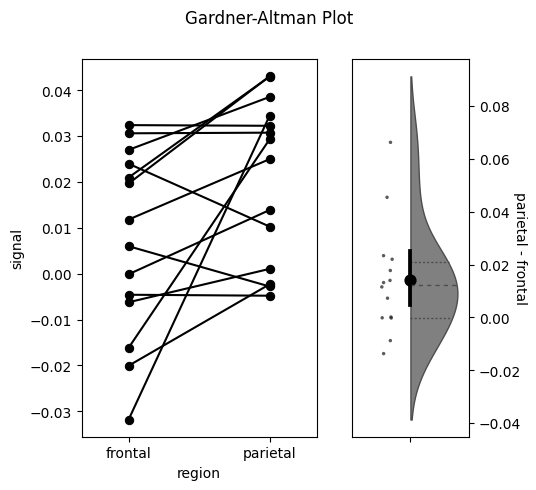

In [4]:
data = df.loc[df['event']=='stim'].drop('event', axis=1)

subject = 'subject'
factor = 'region'
y = 'signal'
a, b = 'frontal', 'parietal'
paired = True


# Get the difference
wide = data.set_index([subject, factor]).unstack(1)
wide.columns = [j for i, j in wide.columns]
diffname = f'{b}_minus_{a}'
wide[diffname] = wide[b] - wide[a]

fig, ax = plt.subplots(1, 2, figsize=(5,5), dpi=100, gridspec_kw={'width_ratios': [2,1]})

if paired:
    # Paired plot
    sns.lineplot(data=data, x=factor, y=y, units=subject, color='k', estimator=None, marker='o', markeredgecolor=None, ax=ax[0])
else:
    sns.swarmplot(data=data, x=factor, y=y, color='k', ax=ax[0])

# Difference plotting
chopplot(plot_type='violin', data=wide, y=diffname, color='grey', linewidth=1, alpha=0.5, side=1, inner='quartile', ax=ax[1])
chopplot(plot_type='strip', data=wide, y=diffname, linewidth=0, alpha=0.75, side=-1, color='k', marker='.', ax=ax[1], zorder=999)
sns.pointplot(data=wide, y=diffname, color='k', zorder=999, ax=ax[1], ci=95)

# Formatting
ax[0].set(xlim=(-1/3, 1+(1/3)))
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position('right')
ax[1].set_ylabel(ax[1].get_ylabel().replace('_', ' ').replace('minus', '-'), rotation=-90)
ax[1].set(xlabel=None)
plt.suptitle('Gardner-Altman Plot')
plt.show()

# Differences

In [5]:
import itertools

In [6]:
df = pd.read_csv('datasets/recognition_fMRI.csv')

df.sample(5)

dprimes = [c for c in df.columns if 'dprime' in c]

df = df[['subject'] + dprimes]
df.columns = [c.replace('_dprime', '').replace('distracter', 'distractor') if ('dprime' in c or 'distracter' in c) else c for c in df.columns]
# Starting data
long = df.melt(id_vars='subject', var_name='condition', value_name='dprime')
long.head()

,subject,condition,dprime
0,4,search_target,0.831970
1,5,search_target,0.684746
2,6,search_target,1.487279
3,7,search_target,0.609556
4,8,search_target,0.960908


In [7]:
data = long.copy()
subject = 'subject'
factor = 'condition'
y = 'dprime'
# --------------------- #

levels = data[factor].unique()
paired_levels = list(itertools.combinations(levels, 2))

# # Wide
# long.set_index([subject, factor]).unstack()
wide = long.pivot_table(values=y, index=subject, columns=factor)

for a, b in paired_levels:
    diffname = '_minus_'.join([a, b]).replace('_', ' ')
    print(diffname)
    wide[diffname] = wide[b] - wide[a]
wide

search target minus search distractor
search target minus capture target
search target minus capture distractor
search distractor minus capture target
search distractor minus capture distractor
capture target minus capture distractor


condition,capture_distractor,capture_target,search_distractor,search_target,search target minus search distractor,search target minus capture target,search target minus capture distractor,search distractor minus capture target,search distractor minus capture distractor,capture target minus capture distractor
subject,,,,,,,,,,
4,0.165154,0.893757,0.531261,0.831970,-0.300709,0.061787,-0.666815,0.362496,-0.366106,-0.728603
5,-0.148050,1.357633,0.684746,0.684746,0.000000,0.672887,-0.832795,0.672887,-0.832795,-1.505683
6,0.785814,1.211347,0.554398,1.487279,-0.932881,-0.275932,-0.701464,0.656949,0.231417,-0.425532
7,0.189041,0.792839,0.504391,0.609556,-0.105165,0.183284,-0.420515,0.288448,-0.315350,-0.603798
8,0.317188,1.229009,0.586843,0.960908,-0.374065,0.268100,-0.643720,0.642166,-0.269655,-0.911820
9,-0.028603,1.377695,0.658429,1.624028,-0.965599,-0.246333,-1.652631,0.719266,-0.687032,-1.406298
10,-0.211497,0.792555,0.416023,0.585643,-0.169620,0.206911,-0.797141,0.376532,-0.627520,-1.004052
11,0.199201,0.299635,0.365497,0.524311,-0.158814,-0.224676,-0.325110,-0.065862,-0.166295,-0.100434
12,0.559590,2.308850,0.614773,0.731922,-0.117149,1.576928,-0.172332,1.694077,-0.055183,-1.749260


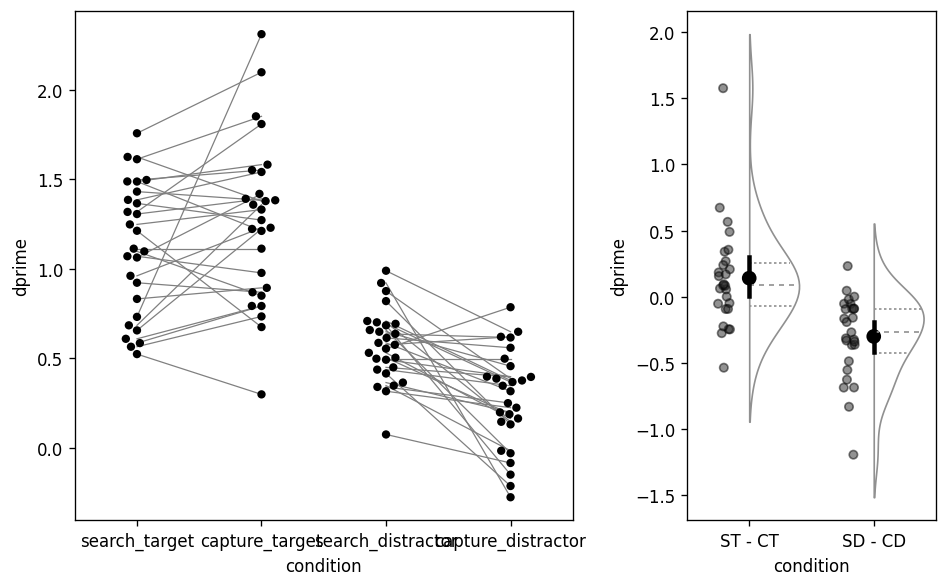

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(8,5), dpi=120, gridspec_kw={'width_ratios': [2,1]})

long['condition'] = pd.Categorical(
    long['condition'],
    categories=[
        'search_target',
        'capture_target',
        'search_distractor',
        'capture_distractor'
    ],
    ordered=True
)

sns.swarmplot(x=factor, y=y, data=long, ax=ax[0], color='k')
sns.lineplot(data=long.loc[long['condition'].isin(['search_target', 'capture_target'])], x=factor, y=y, estimator=None, units=subject, color='grey', lw=0.75, ax=ax[0])
sns.lineplot(data=long.loc[long['condition'].isin(['search_distractor', 'capture_distractor'])], x=factor, y=y, estimator=None, units=subject, color='grey', lw=0.75, ax=ax[0])
lr_buff = 0.5 # left/right buffer
ax[0].set(xlim=([-lr_buff, len(levels)-lr_buff]))

diffdata = wide[['search target minus capture target', 'search distractor minus capture distractor']].melt(value_name='dprime')

chopplot(plot_type='violin', data=diffdata, x='condition', y=y, color='white', linewidth=1, alpha=0.5, side=1, inner='quartile', ax=ax[1])
chopplot(plot_type='strip', data=diffdata, x='condition', y=y, color='k', linewidth=1, alpha=0.5, side=-1, ax=ax[1])
sns.pointplot(data=diffdata, x='condition', y=y, join=False, color='k')
ax[1].set_xticklabels(['ST - CT', 'SD - CD'])

plt.tight_layout()

plt.show()


# Faking multiple level dataset

    obs variable      value
0     1    a - b  -0.949978
1     2    a - b  -7.635291
2     3    a - b  -4.455749
3     4    a - b   0.298045
4     5    a - b  -1.440763
5     6    a - b  -8.277381
6     7    a - b  -6.359977
7     8    a - b  -4.865497
8     9    a - b  -6.040716
9    10    a - b  -1.838264
10    1    a - c  10.792605
11    2    a - c  -0.633653
12    3    a - c   0.285754
13    4    a - c   7.457646
14    5    a - c  -1.005492


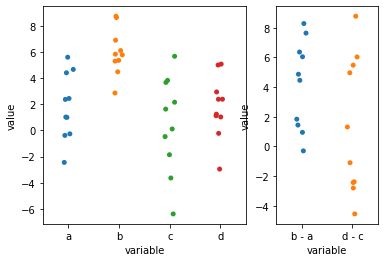

In [117]:
import numpy as np
import pandas as pd
import itertools

n = 10

np.random.seed(0)

df = pd.DataFrame(
    {
        'obs': np.arange(1, n+1),
        'a': np.random.normal(0, 2.5, n),
        'b': np.random.normal(5, 2.5, n),
        'c': np.random.normal(0, 2.5, n),
        'd': np.random.normal(2, 2.5, n)
    }
).melt(id_vars='obs')

def get_diffs(data, id_vars, var_name, value_name):
    # My approach to getting differences
    wide = df.pivot_table(index='obs', values=value_name, columns=var_name)
    # Compute differences
    for a, b in itertools.permutations(df[var_name].unique(), 2):
        wide[f"{a} - {b}"] = wide[a] - wide[b]
    return wide[[c for c in wide.columns if '-' in c]].reset_index().melt(id_vars=id_vars)

# wide = df.pivot_table(index='obs', values='value', columns='variable')

# # Compute differences
# for a, b in itertools.permutations(df['variable'].unique(), 2):
#     wide[f"{a} - {b}"] = wide[a] - wide[b]

# differences = wide[[c for c in wide.columns if '-' in c]].reset_index().melt(id_vars='obs')
# print(differences.head(15))

# # From SO approach
def get_diffs(data, id_vars, var_name='variable', value_name='value'):
    # Adapted from sctackoverflow approach
    groups = data.set_index(id_vars).groupby(var_name)[value_name]
    diffs = {f'{k1} - {k2}': g1-g2 for (k1, g1), (k2, g2) in itertools.permutations(groups, 2)}
    return pd.concat(diffs, names=[var_name]).reset_index()

# differences = get_diffs(data=df, id_vars='obs', var_name='variable', value_name='value')

diffs_to_plot = ['b - a', 'd - c']

fig, ax  =plt.subplots(1,2, gridspec_kw={'width_ratios': [2,1]})

sns.stripplot(x='variable', y='value', data=df, ax=ax[0])
sns.stripplot(x='variable', y='value', data=differences.loc[differences['variable'].isin(diffs_to_plot)], ax=ax[1])

plt.show()

<AxesSubplot:xlabel='variable', ylabel='value'>

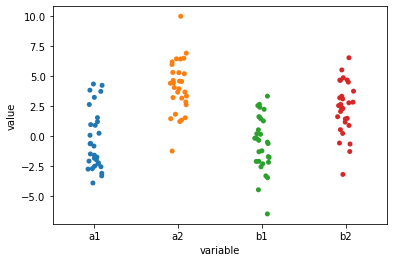

In [32]:
n = 30

df = pd.DataFrame(
    {
        'sub': np.arange(1, n+1),
        'a1': np.random.normal(0, 2.5, n),
        'a2': np.random.normal(5, 2.5, n),
        'b1': np.random.normal(0, 2.5, n),
        'b2': np.random.normal(2, 2.5, n)
    }
)

long = df.melt(id_vars='sub')
long.head()

# # Steps
# Specify vars
x = 'variable'
y = 'value'

# Get all levels and create pairs

pairs = list(itertools.combinations_with_replacement(levels, 2))


sns.stripplot(x=x, y=y, data=long)

,sub,variable,value
0,1,a1,0.603907
1,2,a1,-0.707632
2,3,a1,0.438299
3,4,a1,1.699916
4,5,a1,2.302017
